## **paraphrase-multilingual-mpnet-base-v2 (Multilingual XLM-roBERTa) FINE-TUNING v2**

**CLEAN PYTORCH IMPLEMENTATION**

---

## Description

This notebook presents a comprehensive guide to fine-tuning the ```paraphrase-multilingual-mpnet-base-v2``` model for the task of matching resumes to job vacancies. The primary focus is on developing a binary classifier that predicts whether a given resume matches a job vacancy based on textual content.

## Key Steps:

1. **Data Preprocessing:** The dataset, containing resumes and job vacancies, is loaded and preprocessed. Each entry is labeled as 'confirmed' (1) if the resume matches the vacancy and 'not confirmed' (0) otherwise.

2. **Feature Engineering:** Textual features from both resumes and vacancies are extracted and combined. This includes information such as job titles, descriptions, key skills, and education levels.

3. **Data Augmentation:** To enhance the model's robustness and improve its generalization capabilities, data augmentation techniques such as random deletion and swapping of words are applied to the original textual data. Implementing augmentation resulted in increase in weighted avg accuracy from f1-score 0.4 to 0.7! [Presented here.](https://github.com/gblssroman/MSU-ML-Talent-Match/blob/main/rubert_tiny2_fine_tuning.ipynb)

4. **Dataset Preparation:** The augmented dataset is split into training and validation sets. A custom ```DuoDataset``` class is utilized to handle pairs of text data (resume and vacancy) along with their labels.

5. **Model Setup:** The ```paraphrase-multilingual-mpnet-base-v2``` model is loaded using Hugging Face's Transformers library. The model is adapted for the task by employing mean pooling over token embeddings to derive fixed-size sentence embeddings.

6. **Training:** The model is trained using a contrastive loss function, which is designed to minimize the distance between embeddings of matching resume-vacancy pairs while maximizing the distance for non-matching pairs.

7. **Evaluation:** The trained model's performance is evaluated on the validation set using cosine similarity between resume and vacancy embeddings. The similarity scores are thresholded to make binary predictions.

8. **Threshold Optimization:** Optuna, a hyperparameter optimization framework, is used to find the optimal threshold for converting cosine similarity scores into binary predictions, aiming to maximize the F1 score.

9. **Results Analysis:** The final model's performance is assessed using the optimized threshold, with metrics including F1 score, accuracy, and a detailed classification report.

This notebook provides a practical framework for semantic matching tasks, leveraging transformer models and contrastive learning. It demonstrates the entire workflow from data preparation to model evaluation and optimization, making it a valuable resource for data scientists working on similar natural language processing (NLP) tasks.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cosinesim-ft-talent-v1/COSINESIM_FINETUNE_DATASET_16k_final.csv
/kaggle/input/ml-talent-hack-parsedtrain/output.csv


---
# Here, we assume our dataset for fine-tuning is fully ready (text corpuses are preproccessed, cosine similarity is calcluated):

In [2]:
df = pd.read_csv('/kaggle/input/cosinesim-ft-talent-v1/COSINESIM_FINETUNE_DATASET_16k_final.csv')
df.sample(3)

,CONCATED_x,CONCATED_y,COSINE_SIM
10705,ЗП: 40000 руб.. Ищет работу на должность:: Про...,title: Контролер ОТК Инженер по качеству. sala...,0.477368
9685,ЗП: 25000 руб.. Ищет работу на должность:: Пом...,title: Сотрудник технической поддержки пользов...,0.617403
4106,ЗП: 70000 руб.. Ищет работу на должность:: Сис...,title: Team Lead отдела разработки ВПО микроко...,0.525395


## Let's minimize dataset size here with an attempt to preserve most valuable information:

In [3]:
df_ft1 = df[(df['COSINE_SIM'] < 0.54) & (df['COSINE_SIM'] > 0.52)]
df_ft2 = df[(df['COSINE_SIM'] > 0.63)]
df_ft = pd.concat([df_ft1, df_ft2])
df_ft

,CONCATED_x,CONCATED_y,COSINE_SIM
0,ЗП: 100000 руб.. Ищет работу на должность:: Ве...,title: Начальник ИТ-отдела. salary: от 140000 ...,0.532772
19,ЗП: 100000 руб.. Ищет работу на должность:: Ве...,title: Аналитик Технический писатель. salary: ...,0.522191
26,ЗП: 100000 руб.. Ищет работу на должность:: Ве...,title: Бизнес Аналитикархитектор Внедрение 1С ...,0.533788
29,ЗП: 100000 руб.. Ищет работу на должность:: Ве...,title: Технический писатель IT. salary: з/п не...,0.532743
33,ЗП: 100000 руб.. Ищет работу на должность:: Ве...,title: Инженер по сопровождению. salary: з/п н...,0.536208
...,...,...,...
15815,ЗП: 90000 руб.. Ищет работу на должность:: Fro...,title: DevOps инженер. salary: з/п не указана....,0.639779
15818,ЗП: 90000 руб.. Ищет работу на должность:: Fro...,title: Frontend разработчик. salary: з/п не ук...,0.696150
15827,ЗП: 90000 руб.. Ищет работу на должность:: Fro...,title: Бэкенд-разработчик. salary: от 120000 д...,0.637462
15841,ЗП: 90000 руб.. Ищет работу на должность:: Fro...,title: PHP-программист. salary: от 60000 RUR. ...,0.646838


In [4]:
def round_norm(x):
    if x > 0.56:
        return 1
    else:
        return 0
    
df_ft['COSINE_SIM'] = df_ft['COSINE_SIM'].apply(round_norm)

## Let's import and initialize everything we need:

In [5]:
# !pip install sentence-transformers NO NEED TO IN OUR CASE (we've written everything on clean PyTorch)

In [6]:
from transformers import AutoTokenizer, AutoModel
# from sentence_transformers.losses import ContrastiveLoss
# from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn

model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

#for clean PyTorch this can be used:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] 
    #as it contains all embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    #att mask size -> token embs size
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    #paddings to zero
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    #normalization excluding zero
    
    return sum_embeddings / sum_mask #returning avg

#for simplicity let's use one already incl. pooling
# model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

### Case without splitting texts into corpuses as we will fine-tune on the full corpus data embeddings' similarity with dropping several columns (check README for reference):

In [7]:
val_data = pd.read_csv('/kaggle/input/ml-talent-hack-parsedtrain/output.csv')
cols = list(np.array(val_data.columns))
print(cols)

['Vacancy UUID', 'Vacancy Name', 'Keywords', 'Description', 'Comment', 'Resume UUID', 'First Name', 'Last Name', 'Birth Date', 'Country', 'City', 'About', 'Key Skills', 'Starts', 'Ends', 'Employer', 'Experience City', 'Position', 'Experience Description', 'Year', 'Organization', 'Faculty', 'Specialty', 'Result', 'Education Type', 'Education Level', 'Target']


In [8]:
cols_drop1 = cols[0:9] + cols[13:16] + [cols[19]] + [cols[-1]]
resumes_val = val_data.drop(columns=cols_drop1)
vac_val = val_data.iloc[:, 1:5]
labels_val = np.array(pd.get_dummies(val_data.iloc[:, -1]).astype(int).drop(columns='failed')).tolist()

In [9]:
resumes_val_text = []
for i in range(len(resumes_val)):
    curr_str = ""
    for j in range(len(resumes_val.columns)):
        if not pd.isna(resumes_val.iloc[i, j]):
            curr_str += str(resumes_val.iloc[i, j]) + ". "
    resumes_val_text.append(curr_str)
vac_val_text = []
for i in range(len(vac_val)):
    curr_str = ""
    for j in range(len(vac_val.columns)):
        if not pd.isna(vac_val.iloc[i, j]):
            curr_str += str(vac_val.iloc[i, j]) + ". "
    vac_val_text.append(curr_str)

In [10]:
len(vac_val_text), len(resumes_val_text), len(labels_val)

(656, 656, 656)

In [11]:
from torch.utils.data import DataLoader, Dataset

COMBINED_TRAIN_RES = resumes_val_text.copy()
COMBINED_TRAIN_VAC = vac_val_text.copy()
COMBINED_TRAIN_LBL = labels_val.copy()

COMBINED_TRAIN_RES.extend(df_ft.iloc[:, 0].tolist())
COMBINED_TRAIN_VAC.extend(df_ft.iloc[:, 1].tolist())
COMBINED_TRAIN_LBL.extend(np.array(df_ft.iloc[:, 2].tolist()).reshape(-1, 1).tolist())

class DuoDataset(Dataset):
    def __init__(self, text1, text2, labels=None):
        self.text1 = np.array(text1)
        self.text2 = np.array(text2)
        if len(labels) > 0:
            self.labels = torch.tensor(labels, dtype=torch.float32)
        
    def __len__(self):
        return len(self.text1)
    
    def __getitem__(self, idx):
        text1_sample = self.text1[idx]
        text2_sample = self.text2[idx]
        
        if len(self.labels) > 0:
            label = self.labels[idx]
            return text1_sample, text2_sample, label
        else:
            return text1_sample, text2_sample
    
val_dataset = DuoDataset(resumes_val_text, vac_val_text, labels=labels_val)
train_dataset = DuoDataset(COMBINED_TRAIN_RES, COMBINED_TRAIN_VAC, labels=COMBINED_TRAIN_LBL)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=8)

---
# Testing metrics first:
### With threshold = 0.75

In [95]:
from tqdm import tqdm
from IPython.display import clear_output
eval_preds, eval_labels, cossims = [], [], []

model.to('cuda')
model.eval()
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        clear_output()
        texts1, texts2, labels = batch
        inp1 = tokenizer(texts1, padding=True, truncation=True,
                        return_tensors='pt').to('cuda')
        inp2 = tokenizer(texts2, padding=True, truncation=True,
                        return_tensors='pt').to('cuda')
        inp1 = {key: val.to('cuda') for key, val in inp1.items()}
        inp2 = {key: val.to('cuda') for key, val in inp2.items()}
        
        out1 = model(**inp1)
        out2 = model(**inp2)
            
        emb1 = mean_pooling(out1, inp1['attention_mask'])
        emb2 = mean_pooling(out2, inp2['attention_mask'])
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        preds = (cos_sim > 0.7).int() #ideal ~0.7 in distrib. proportion (W/O FINETUNE)
        cossims.append(cos_sim.cpu().tolist())
        eval_preds.append(preds.cpu().tolist())
        eval_labels.append(labels.cpu().tolist())

100%|██████████| 82/82 [00:22<00:00,  3.64it/s]


### Default model with threshold = 0.75:

In [24]:
from sklearn.metrics import classification_report

print(classification_report(eval_labels.flatten().tolist(), eval_preds.flatten().tolist())) #0.75 THR. NON-TRAINED

              precision    recall  f1-score   support

         0.0       0.71      0.87      0.78       463
         1.0       0.31      0.14      0.19       193

    accuracy                           0.66       656
   macro avg       0.51      0.51      0.49       656
weighted avg       0.59      0.66      0.61       656



### Acheiving 0.66 ACCURACY MAX. and other metrics displayed above in adequate bounds. 
### Acceptable for full corpus texts, but we want more.

---
**Misc. code for CUDA cache cleaning:**

In [42]:
# # #Cleaning cache
# import gc
# gc.collect()
# del model
# torch.cuda.empty_cache()
# gc.collect()

0

---
# TRAIN FUNCTION & VALIDATION:

In [12]:
from transformers import AdamW
from sklearn.metrics import classification_report
from tqdm import tqdm
import time
from IPython.display import clear_output

class ContrastiveLoss_v1(nn.Module):
    def __init__(self, margin=0.2):
        super(ContrastiveLoss_v1, self).__init__()
        self.margin = margin

    def forward(self, y1, y2, label):
        # Calculate the cosine similarity
        cos_sim = nn.functional.cosine_similarity(y1, y2)

        # Contrastive loss calculation FIXED
        # If label is 1 (meaning y1 and y2 are similar), we want 1-cos_sim to be 0, so we minimize (1 - cos_sim)
        # If label is 0 (meaning y1 and y2 are different), we want 1-cos_sim to be less than margin, so we minimize max(0, cos_sim - margin)
        loss_positive = ((1 - cos_sim)**2)/2 * label  # Loss for similar pairs
        loss_negative = (((cos_sim - self.margin).clamp(min=0))**2)/2 * (1-label)  # Loss for dissimilar pairs

        # Combine the losses
        loss = loss_positive + loss_negative
        return loss.mean()


model.to('cuda')

loss_func = ContrastiveLoss_v1()
optimizer = AdamW(model.parameters(), lr=2e-5)

NUM_EPOCHS = 3 #3
ALL_LOSSES, ALL_VAL_LOSSES = [], []

for epoch in tqdm(range(NUM_EPOCHS)):
    print(f"EPOCH {epoch+1}")
    if epoch == 0:
        model.eval()
        eval_preds, eval_preds1, eval_preds2 = [], [], []
        with torch.no_grad():
            val_loss = 0
            for step, batch in enumerate(val_dataloader):

                texts1, texts2, labels = batch
                inp1 = tokenizer(texts1, padding=True, truncation=True,
                                return_tensors='pt').to('cuda')
                inp2 = tokenizer(texts2, padding=True, truncation=True,
                                return_tensors='pt').to('cuda')
                inp1 = {key: val.to('cuda') for key, val in inp1.items()}
                inp2 = {key: val.to('cuda') for key, val in inp2.items()}

                out1 = model(**inp1)
                out2 = model(**inp2)

                emb1 = mean_pooling(out1, inp1['attention_mask'])
                emb2 = mean_pooling(out2, inp2['attention_mask'])

                loss = loss_func(emb1.to('cuda'), emb2.to('cuda'), labels.to('cuda'))
                val_loss = loss.item()

                cos_sim = nn.functional.cosine_similarity(emb1, emb2)

                avg_val_loss = val_loss / len(val_dataloader)
                ALL_VAL_LOSSES.append(avg_val_loss)
                print(f"Validation loss: {avg_val_loss}\n")

    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}", unit="batch")):
        optimizer.zero_grad()
        
        clear_output(wait=True)
        texts1, texts2, labels = batch
        inp1 = tokenizer(texts1, padding=True, truncation=True,
                        return_tensors='pt').to('cuda')
        inp2 = tokenizer(texts2, padding=True, truncation=True,
                        return_tensors='pt').to('cuda')
        inp1 = {key: val.to('cuda') for key, val in inp1.items()}
        inp2 = {key: val.to('cuda') for key, val in inp2.items()}
        
        out1 = model(**inp1)
        out2 = model(**inp2)
            
        emb1 = mean_pooling(out1, inp1['attention_mask'])
        emb2 = mean_pooling(out2, inp2['attention_mask'])

        loss = loss_func(emb1.to('cuda'), emb2.to('cuda'), labels.to('cuda'))
        loss.backward()
        optimizer.step()
        
        total_loss = loss.item()
        
        avg_loss = total_loss / len(batch) # Yes, we're tracking losses on each batch (can be changed)
        ALL_LOSSES.append(avg_loss)
        print(f"Step {step}: Loss - {avg_loss}")
    
    ###val below
    
    model.eval()
    eval_preds, eval_preds1, eval_preds2 = [], [], []
    with torch.no_grad():
        val_loss = 0
        for step, batch in enumerate(val_dataloader):
            
            texts1, texts2, labels = batch
            inp1 = tokenizer(texts1, padding=True, truncation=True,
                            return_tensors='pt').to('cuda')
            inp2 = tokenizer(texts2, padding=True, truncation=True,
                            return_tensors='pt').to('cuda')
            inp1 = {key: val.to('cuda') for key, val in inp1.items()}
            inp2 = {key: val.to('cuda') for key, val in inp2.items()}

            out1 = model(**inp1)
            out2 = model(**inp2)

            emb1 = mean_pooling(out1, inp1['attention_mask'])
            emb2 = mean_pooling(out2, inp2['attention_mask'])
            
            loss = loss_func(emb1.to('cuda'), emb2.to('cuda'), labels.to('cuda'))
            val_loss = loss.item()
            
            cos_sim = nn.functional.cosine_similarity(emb1, emb2)
    
            avg_val_loss = val_loss / len(val_dataloader)
            ALL_VAL_LOSSES.append(avg_val_loss)
            print(f"Validation loss: {avg_val_loss}\n")


Epoch 3: 100%|██████████| 451/451 [06:46<00:00,  1.11batch/s]

Step 450: Loss - 0.025132474799950916


Validation loss: 2.840785991127898e-05

Validation loss: 0.0021030577581103256

Validation loss: 0.0007507006024442068

Validation loss: 0.0002100926755768497

Validation loss: 0.0017276248190461136

Validation loss: 0.0007777259480662462

Validation loss: 5.5463814244764604e-05

Validation loss: 0.0010473933525201751

Validation loss: 0.00020802666137858134

Validation loss: 0.0002198189542424388

Validation loss: 0.0009693906801502879

Validation loss: 0.00227668772383434

Validation loss: 0.0022690830434240945

Validation loss: 0.0011693533600830451

Validation loss: 0.0005577020801422073

Validation loss: 0.0020170660644042784

Validation loss: 0.0011443348556030087

Validation loss: 0.0016534339363982037

Validation loss: 3.392751067422512e-05

Validation loss: 4.046504022326411e-05

Validation loss: 3.7387246266007423e-05

Validation loss: 3.473725306188188e-05

Validation loss: 0.0016338930624287303

Validation loss: 0.0031987704881807654

Validation loss: 0.00043896622047191714

100%|██████████| 3/3 [21:46<00:00, 435.39s/it]

Validation loss: 0.003263690486186888



## And here are final loss function graphs:

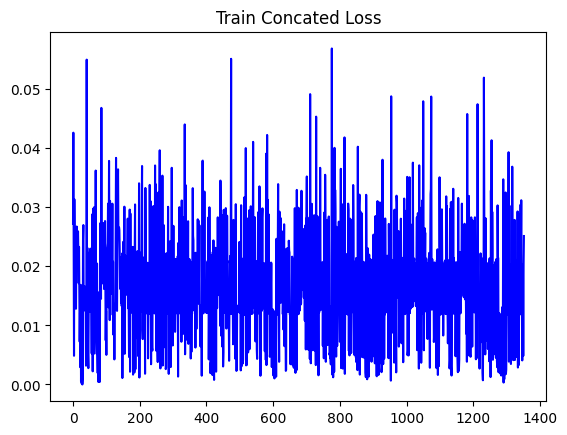

In [18]:
import matplotlib.pyplot as plt

plt.title("Train Concated Loss")
plt.plot(ALL_LOSSES, color='blue'); #train loss

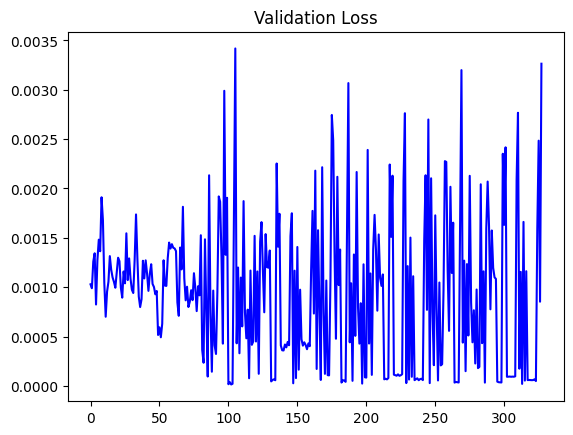

In [19]:
plt.title("Validation Loss")
plt.plot(ALL_VAL_LOSSES, color='blue');

## Inference & metrics:

In [27]:
eval_preds, eval_labels, cossims = [], [], []
model.to('cuda')
model.eval()
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        clear_output()
        texts1, texts2, labels = batch
        inp1 = tokenizer(texts1, padding=True, truncation=True,
                        return_tensors='pt').to('cuda')
        inp2 = tokenizer(texts2, padding=True, truncation=True,
                        return_tensors='pt').to('cuda')
        inp1 = {key: val.to('cuda') for key, val in inp1.items()}
        inp2 = {key: val.to('cuda') for key, val in inp2.items()}
        
        out1 = model(**inp1)
        out2 = model(**inp2)
            
        emb1 = mean_pooling(out1, inp1['attention_mask'])
        emb2 = mean_pooling(out2, inp2['attention_mask'])
        cos_sim = nn.functional.cosine_similarity(emb1, emb2)
        preds = (cos_sim > 0.35).int() # Threshold referring to distribution displayed below
        cossims.append(cos_sim.cpu().tolist())
        eval_preds.append(preds.cpu().tolist())
        eval_labels.append(labels.cpu().tolist())
        
eval_preds = np.array(eval_preds).reshape(-1, 1)
eval_labels = np.array(eval_labels).reshape(-1, 1)
cossims = np.array(cossims).reshape(-1, 1)

100%|██████████| 82/82 [00:21<00:00,  3.78it/s]


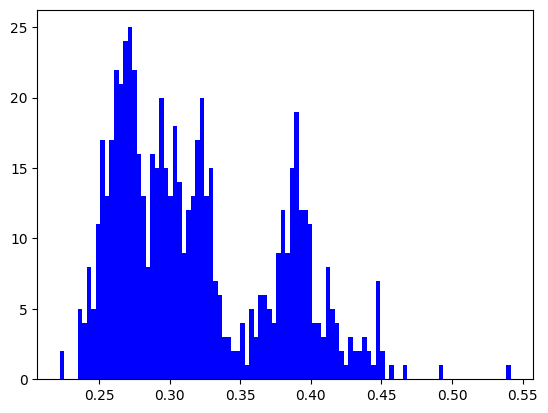

In [28]:
import matplotlib.pyplot as plt

plt.hist(cossims, bins=100, color='blue');

In [29]:
import matplotlib.pyplot as plt
from collections import Counter

Counter(eval_preds.flatten().tolist()), Counter(eval_labels.flatten().tolist())

(Counter({0: 466, 1: 190}), Counter({0.0: 463, 1.0: 193}))

In [31]:
from sklearn.metrics import classification_report

thresholds = np.arange(0.3, 0.4, 0.01)
print(thresholds)

for i in thresholds:
    cossims_temp = (torch.tensor(cossims) > i).int().cpu().flatten().tolist()

    print(classification_report(eval_labels.flatten().tolist(), cossims_temp))

### **It showed out, that threshold == 0.38 performs in the most adequate way, so we're sticking to it with final metrics equal to:**

In [35]:
cossims_temp = (torch.tensor(cossims) > 0.38).int().cpu().flatten().tolist()
print(classification_report(eval_labels.flatten().tolist(), cossims_temp))

              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78       463
         1.0       0.42      0.30      0.35       193

    accuracy                           0.67       656
   macro avg       0.58      0.56      0.57       656
weighted avg       0.65      0.67      0.65       656



### ***Please note that there is a notable bias in the final distribution and margin should be adjusted according to the train dataset you are using and the task you are achieving.***
### If you split dataset into two parts (key features etc.) and full text, model (or final ensemble of models) normally would perform better since there is less noise and more straightforward information in the first part's case. This notebook just shows the approach and reference for model tuning. 
### Here is a nice illustration showing us how to choose a margin:

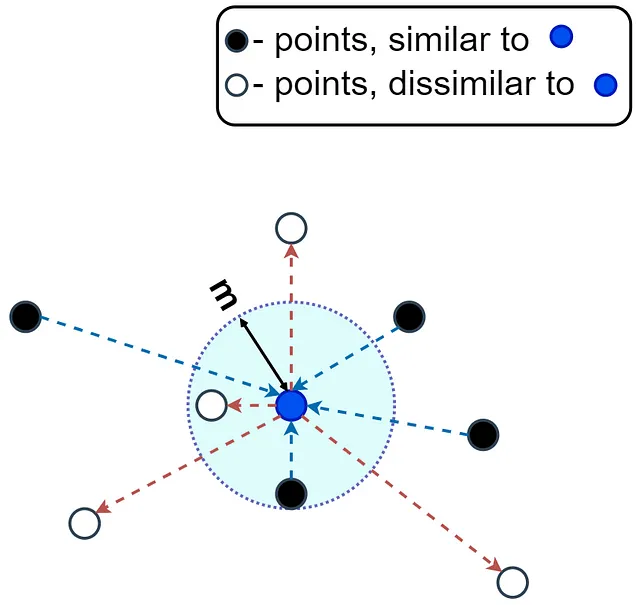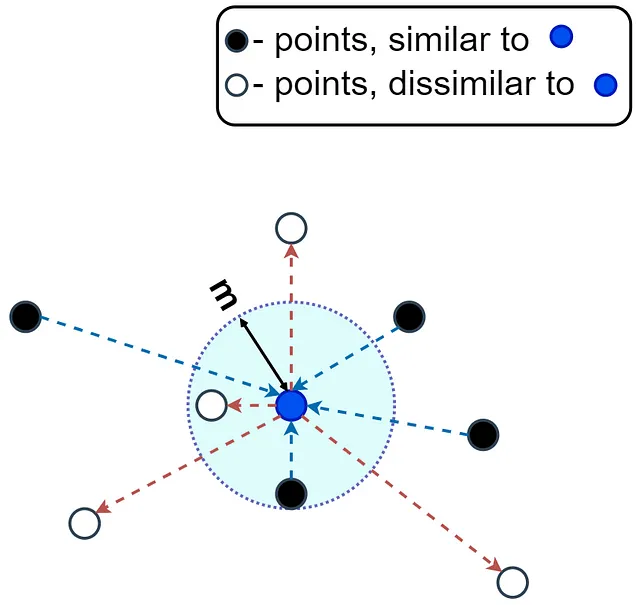

---
### Saving model to safetensors + json, then zipping it:

In [36]:
model.save_pretrained('XLMroBERTa_fine_tuned')

In [37]:
!zip XLMroBERTa_fine_tuned.zip /kaggle/working/XLMroBERTa_fine_tuned/*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/XLMroBERTa_fine_tuned/config.json (deflated 49%)
  adding: kaggle/working/XLMroBERTa_fine_tuned/model.safetensors (deflated 9%)
